# Leer datasets

In [2]:
import pandas as pd
import numpy as np

blob = pd.read_csv('../data/blob3.csv')
blob.head()

,X1,X2,label
0,-8.160057,-5.125315,2
1,-5.128943,9.836189,0
2,-7.125370,-7.152833,2
3,5.614999,1.826112,1
4,-1.938307,10.149852,0


In [3]:
blob.drop(columns=['label'], inplace=True)

# Realizamos los clusters

In [4]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(blob)
kmeans_labels = kmeans.labels_
dbscan = DBSCAN(eps=0.7, min_samples=5)
dbscan.fit(blob)
dbscan_labels = dbscan.labels_
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm.fit(blob)
gmm_labels = gmm.predict(blob)

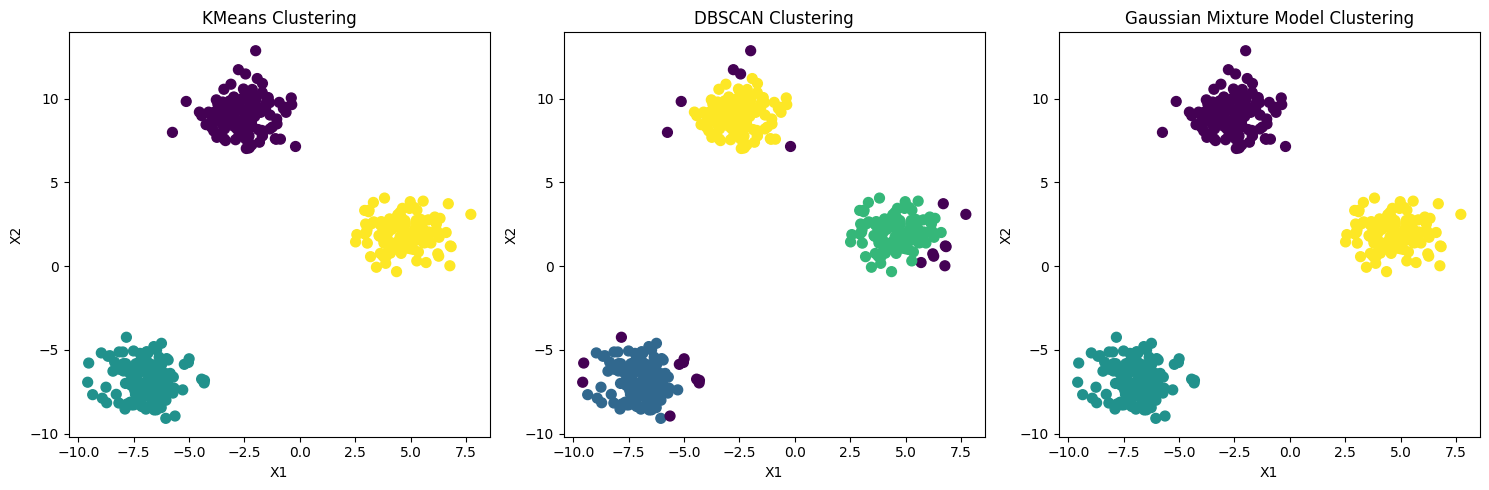

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(blob.iloc[:, 0], blob.iloc[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title('KMeans Clustering')
plt.xlabel(blob.columns[0])
plt.ylabel(blob.columns[1])
plt.subplot(1, 3, 2)
plt.scatter(blob.iloc[:, 0], blob.iloc[:, 1], c=dbscan_labels, cmap='viridis', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel(blob.columns[0])
plt.ylabel(blob.columns[1])
plt.subplot(1, 3, 3)
plt.scatter(blob.iloc[:, 0], blob.iloc[:, 1], c=gmm_labels, cmap='viridis', s=50)
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel(blob.columns[0])
plt.ylabel(blob.columns[1])
plt.tight_layout()
plt.show()

In [6]:
from sklearn.metrics import silhouette_score
kmeans_silhouette = silhouette_score(blob, kmeans_labels)
dbscan_silhouette = silhouette_score(blob, dbscan_labels)
gmm_silhouette = silhouette_score(blob, gmm_labels)
print(f'KMeans Silhouette Score: {kmeans_silhouette:.2f}')
print(f'DBSCAN Silhouette Score: {dbscan_silhouette:.2f}')
print(f'Gaussian Mixture Model Silhouette Score: {gmm_silhouette:.2f}')

KMeans Silhouette Score: 0.85
DBSCAN Silhouette Score: 0.74
Gaussian Mixture Model Silhouette Score: 0.85


# Interpretar

In [7]:
import sys
sys.path.append('..')
from ripper import MultiClassRipperClassifier
from dsgd import DSClassifierMultiQ
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree as sk_tree

## Kmeans

In [8]:
#dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(blob, kmeans_labels, test_size=0.2, random_state=42)


In [9]:
#muestrame los centros de los clusters
centers = kmeans.cluster_centers_
print("KMeans Cluster Centers:")
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

KMeans Cluster Centers:
Cluster 0: [-2.58785774  9.04994921]
Cluster 1: [-6.91665272 -6.83514682]
Cluster 2: [4.67199169 1.90826925]


In [10]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 1.00


In [11]:
ripper.print_rules()


Reglas para clase: 0
[[X1=-3.51--2.58] V [X1=-2.58--2.0] V [X1=-2.0-3.02^X2=>9.63] V [X2=7.72-8.78] V [X2=8.78-9.63] V [X1=-2.0-3.02^X2=2.67-7.72] V [X1=-6.01--3.51^X2=2.67-7.72] V [X2=>9.63]]

Reglas para clase: 1
[[X2=-6.73--5.56] V [X2=-7.39--6.73] V [X2=<-7.39] V [X2=-5.56-1.05^X1=-6.7--6.01] V [X2=-5.56-1.05^X1=<-7.4] V [X2=-5.56-1.05^X1=-6.01--3.51] V [X1=-7.4--6.7]]

Reglas para clase: 2
[[X2=1.05-1.84] V [X2=1.84-2.67] V [X1=>5.14] V [X1=3.02-4.41] V [X1=4.41-5.14]]


Decision Tree Accuracy: 1.00


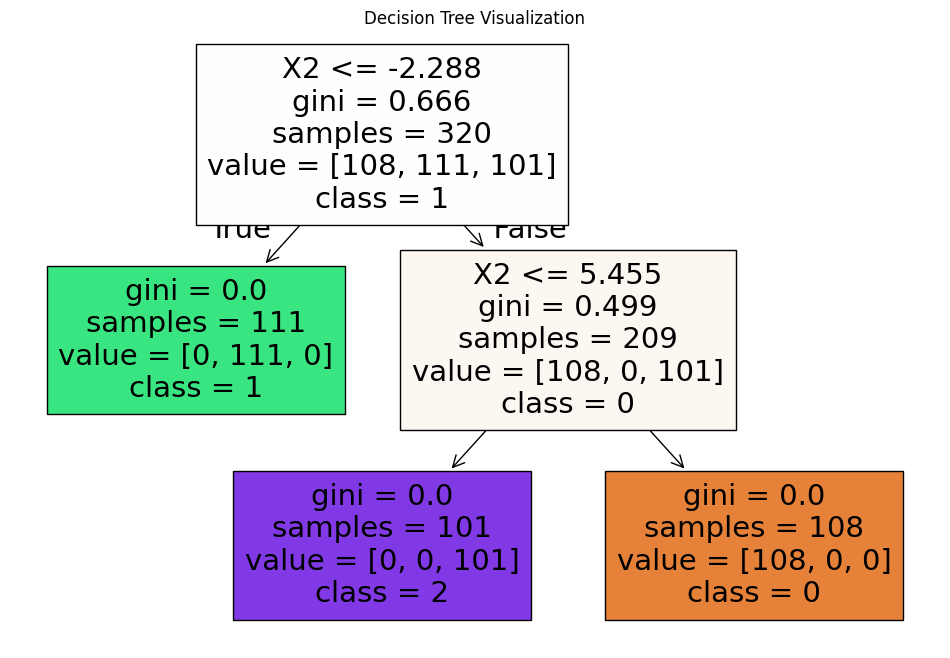

In [12]:
tree = DecisionTreeClassifier(random_state=44)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=blob.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [13]:
ds = DSClassifierMultiQ(n_clusters, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=blob.columns.tolist())


Optimization started

Training time: 10.96s, epochs: 200

Least training loss reached: 0.014


In [14]:
ds.print_most_important_rules(threshold=0.32)



Most important rules for class 0

	[0.701] R7: X2 > 5.762
			0: 0.701	1: 0.000	2: 0.000	Unc: 0.299

	[0.700] R2: -1.796 < X1 < 1.488
			0: 0.700	1: 0.000	2: 0.000	Unc: 0.300

	[0.691] R1: -5.079 < X1 < -1.796
			0: 0.691	1: 0.000	2: 0.000	Unc: 0.309

Most important rules for class 1

	[0.763] R0: X1 < -5.079
			0: 0.000	1: 0.763	2: 0.000	Unc: 0.237

	[0.657] R4: X2 < -3.204
			0: 0.000	1: 0.657	2: 0.000	Unc: 0.343

Most important rules for class 2

	[0.772] R3: X1 > 1.488
			0: 0.000	1: 0.000	2: 0.772	Unc: 0.228

	[0.676] R5: -3.204 < X2 < 1.279
			0: 0.000	1: 0.000	2: 0.676	Unc: 0.324

	[0.672] R6: 1.279 < X2 < 5.762
			0: 0.000	1: 0.000	2: 0.672	Unc: 0.328


In [15]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 0.99


## DBSCAN

In [16]:
#dividir los datos en entrenamiento y prueba
n_clusters_dbscan = len(np.unique(dbscan_labels))
max_label = np.max(dbscan_labels)
dbscan_labels = np.where(dbscan_labels == -1, max_label + 1, dbscan_labels)  # Assign a new label for noise points
X_train, X_test, y_train, y_test = train_test_split(blob, dbscan_labels, test_size=0.2, random_state=42)


In [17]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 0.94


In [18]:
ripper.print_rules()


Reglas para clase: 0
[[X2=-6.73--5.56^X1=-6.7--6.01] V [X2=<-7.39] V [X2=-7.39--6.73] V [X2=-6.73--5.56^X1=-7.4--6.7] V [X1=<-7.4] V [X1=-6.7--6.01] V [X1=-7.4--6.7] V [X2=-6.73--5.56]]

Reglas para clase: 1
[[X2=1.84-2.67] V [X2=1.05-1.84] V [X2=2.67-7.72^X1=4.41-5.14] V [X1=3.02-4.41] V [X1=>5.14^X2=2.67-7.72] V [X2=-5.56-1.05^X1=4.41-5.14] V [X1=>5.14]]

Reglas para clase: 2
[[X1=-3.51--2.58] V [X2=7.72-8.78] V [X2=>9.63^X1=-2.0-3.02] V [X1=-2.58--2.0] V [X2=8.78-9.63] V [X2=2.67-7.72^X1=-2.0-3.02]]

Reglas para clase: 3
[[X1=-6.01--3.51^X2=-6.73--5.56] V [X1=>5.14^X2=-5.56-1.05]]


Decision Tree Accuracy: 0.94


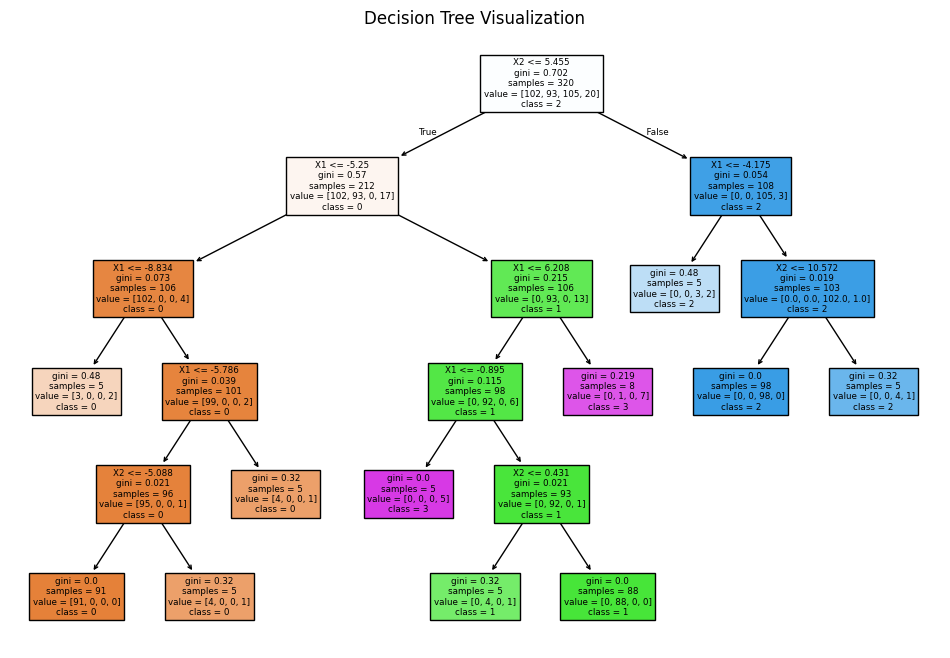

In [19]:
tree = DecisionTreeClassifier(random_state=44, min_samples_leaf=5)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=blob.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [20]:
ds = DSClassifierMultiQ(n_clusters_dbscan, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=blob.columns.tolist())


Optimization started

Training time: 10.86s, epochs: 200

Least training loss reached: 0.031


In [21]:
ds.print_most_important_rules(threshold=0.001)



Most important rules for class 0

	[0.744] R0: X1 < -5.079
			0: 0.744	1: 0.000	2: 0.000	3: 0.000	Unc: 0.256

	[0.725] R4: X2 < -3.204
			0: 0.725	1: 0.000	2: 0.000	3: 0.000	Unc: 0.275

Most important rules for class 1

	[0.767] R6: 1.279 < X2 < 5.762
			0: 0.000	1: 0.767	2: 0.000	3: 0.000	Unc: 0.233

	[0.708] R3: X1 > 1.488
			0: 0.000	1: 0.708	2: 0.000	3: 0.000	Unc: 0.292

	[0.697] R5: -3.204 < X2 < 1.279
			0: 0.000	1: 0.486	2: 0.000	3: 0.513	Unc: 0.001

Most important rules for class 2

	[0.752] R7: X2 > 5.762
			0: 0.000	1: 0.000	2: 0.752	3: 0.000	Unc: 0.248

	[0.751] R2: -1.796 < X1 < 1.488
			0: 0.000	1: 0.000	2: 0.751	3: 0.000	Unc: 0.249

	[0.732] R1: -5.079 < X1 < -1.796
			0: 0.000	1: 0.000	2: 0.732	3: 0.000	Unc: 0.268

Most important rules for class 3

	[0.716] R5: -3.204 < X2 < 1.279
			0: 0.000	1: 0.486	2: 0.000	3: 0.513	Unc: 0.001


In [22]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 0.95


## GMM

In [23]:
#dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(blob, gmm_labels, test_size=0.2, random_state=42)


In [24]:
ripper = MultiClassRipperClassifier(random_state=43)
ripper.fit(X_train, y_train)
y_pred_ripper = ripper.predict(X_test)
print(f'Ripper Accuracy: {accuracy_score(y_test, y_pred_ripper):.2f}')

Ripper Accuracy: 1.00


In [25]:
ripper.print_rules()


Reglas para clase: 0
[[X1=-3.51--2.58] V [X1=-2.58--2.0] V [X1=-2.0-3.02^X2=>9.63] V [X2=7.72-8.78] V [X2=8.78-9.63] V [X1=-2.0-3.02^X2=2.67-7.72] V [X1=-6.01--3.51^X2=2.67-7.72] V [X2=>9.63]]

Reglas para clase: 1
[[X2=-6.73--5.56] V [X2=-7.39--6.73] V [X2=<-7.39] V [X2=-5.56-1.05^X1=-6.7--6.01] V [X2=-5.56-1.05^X1=<-7.4] V [X2=-5.56-1.05^X1=-6.01--3.51] V [X1=-7.4--6.7]]

Reglas para clase: 2
[[X2=1.05-1.84] V [X2=1.84-2.67] V [X1=>5.14] V [X1=3.02-4.41] V [X1=4.41-5.14]]


Decision Tree Accuracy: 1.00


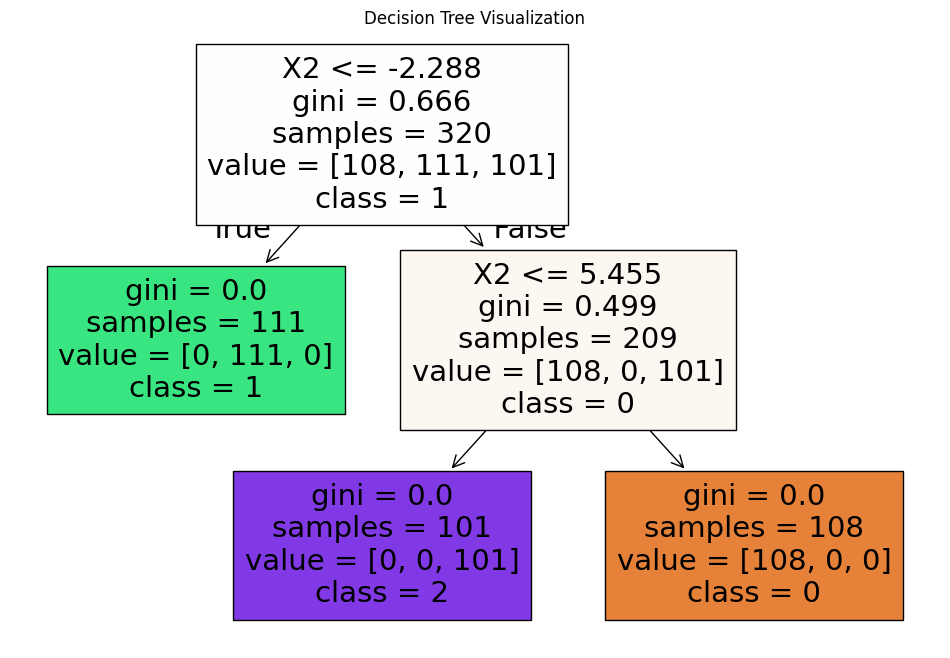

In [26]:
tree = DecisionTreeClassifier(random_state=44)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(f'Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}')
# tree visualization
plt.figure(figsize=(12, 8))
sk_tree.plot_tree(tree, filled=True, feature_names=blob.columns, class_names=[str(i) for i in np.unique(y_train)])
plt.title('Decision Tree Visualization')
plt.show()

In [27]:
ds = DSClassifierMultiQ(n_clusters, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
X_train = X_train.to_numpy()
losses, epoch, dt = ds.fit(X_train, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=blob.columns.tolist())


Optimization started

Training time: 10.54s, epochs: 200

Least training loss reached: 0.013


In [28]:
ds.print_most_important_rules(threshold=0.32)



Most important rules for class 0

	[0.729] R7: X2 > 5.762
			0: 0.729	1: 0.000	2: 0.000	Unc: 0.271

	[0.692] R2: -1.796 < X1 < 1.488
			0: 0.692	1: 0.000	2: 0.000	Unc: 0.308

	[0.660] R1: -5.079 < X1 < -1.796
			0: 0.660	1: 0.000	2: 0.000	Unc: 0.340

Most important rules for class 1

	[0.736] R4: X2 < -3.204
			0: 0.000	1: 0.736	2: 0.000	Unc: 0.264

	[0.709] R0: X1 < -5.079
			0: 0.000	1: 0.709	2: 0.000	Unc: 0.291

Most important rules for class 2

	[0.733] R6: 1.279 < X2 < 5.762
			0: 0.000	1: 0.000	2: 0.733	Unc: 0.267

	[0.723] R5: -3.204 < X2 < 1.279
			0: 0.000	1: 0.000	2: 0.723	Unc: 0.277

	[0.693] R3: X1 > 1.488
			0: 0.000	1: 0.000	2: 0.693	Unc: 0.307


In [29]:
x_test = X_test.to_numpy()
y_pred_ds = ds.predict(x_test)
print(f'DSClassifier Accuracy: {accuracy_score(y_test, y_pred_ds):.2f}')

DSClassifier Accuracy: 1.00
